# Strong and Weak Ties

**Prerequisites**

- Introduction to Graphs

**Outcomes**

- Recognize open and closed triangles in a graph
- Understand concept of tradic closure
- Be able to identify global and local bridges in a network: visually and programatically
- Understand the "strength of weak ties"
- Be familiar with betwenness centrality and its use in graph partitioning

**References**

- [Easley and Kleinberg](https://www.cs.cornell.edu/home/kleinber/networks-book/) chapter 3

## Granovetter's question

- In the late 1960s a PhD student Mark Granovetter wanted to understand how people get a new job
- He interviewed many people who recently changed firms and asked how they got their job
- Unsurprisingly, people said they got referrals or learned about the job from personal contacts
- Surprisingly, most people said the contacts were made via their "aquaintances" and not "friends"
- Why?

### Graphs for Information Flow

- To answer Granovetter's question, we'll turn to graphs
- As we'll see, this is one of many possible examples of how we can use a graph to study the **flow of information**
  - What other examples are there?
  - From what sources do you get your information?
  - Do you get different *types* of information from different *types* of source? Why?
- One interesting point to make in this regard is that by studying information flow via graphs we are making taking something inherently *interpersonal* or emotional (frienships and sharing information) and analyzing it from a *structural* perspective (as a graph)
- Keep these themes in mind as we study the theoreitcal/techinical tools
- We'll return back to the question Granovetter's question after building up some tools

## Triangles

- When studying graphs, the smallest possible structure involving more than two nodes is a triangle
- Triangles are made up of three nodes and either two or three edges that connect them
  - A triangle with only two edges is said to be *open*
  - A triangle with three edges is *closed*
- In the example below, there are 3 triangles, all of which are open

In [2]:
import numpy as np
import networkx as nx

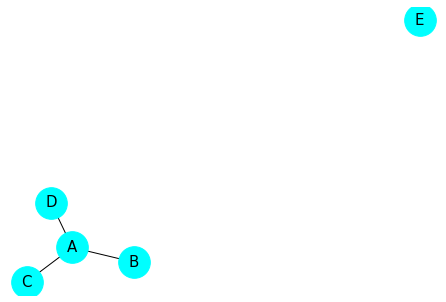

In [3]:
g1 = nx.star_graph("A B C D".split())
g1.add_node("E")
plot_kw = dict(font_size=15, node_color="cyan", node_size=1000, with_labels=True)
nx.draw(g1, **plot_kw)

### Social Triangles

- Suppose our graph is of students arriving for first year of college
- Each node is a student
- An edge represents a friendship or connection between students
- Story... 
  - `A` went to and out of school state, but happened to know `B`, `C`, and `D` from various summer camps or family-friend relationships
  - None of `B`, `C` and `D` know one another
  - `E` is a student from a foreign country who doesn't know any of the other four students
- Question: Given only this information, is it more likely that `B` and `E` become friends, or `B` and `C`? Why?

### Closing triangles

- In our example graph the only edges are between A and another node
- Consider a triangle formed by nodes A, B, C
- To *close* this triangle, there would need to be a node between B-C as follows

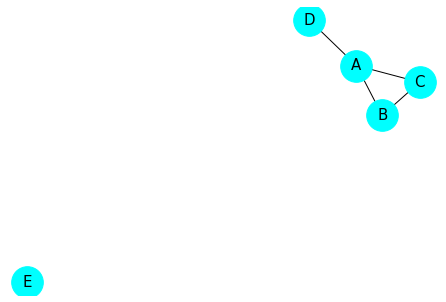

In [4]:
g2 = g1.copy()
g2.add_edge("B", "C")
nx.draw(g2, **plot_kw)

### Triadic Closure

- There is overwhelming empirical evidence to support the intuition that when there are edges A-B and A-C, it is likely that an edge B-C will form
    - This means it is more likely that `B-C` forms than `B-E`
- This is known as **triadic closure** (closing the final edge of a triangle)
- For this reason, when analyzing social network data it is very common to see triangles

### Triangles with networkx

- There is good support in networkx for helping us count triangles in a graph
- The key function is `nx.triangles(g)`
- It computes the number of closed triangles each node is a part of

In [5]:
nx.triangles(g2)

{'A': 1, 'B': 1, 'C': 1, 'D': 0, 'E': 0}

### Clustering Coefficients

- It is helpful to have a single number summary of how "closed" a graphs' triangles are
- The **clustering coefficient** tells us the fraction of triangles that are closed
- There is a local flavor, where we consider all triangles for a specific node
- There is also a global flavor where we consider all triangles for the entire graph
- network has functions `nx.clustering(g)` that computes the local clustering coefficient for each node and `nx.transivitiy` that computes the global variant

In [6]:
nx.clustering(g2)

{'A': 0.3333333333333333, 'B': 1.0, 'C': 1.0, 'D': 0, 'E': 0}

In [7]:
nx.transitivity(g2)

0.6

## Bridges

- Consider the graph below

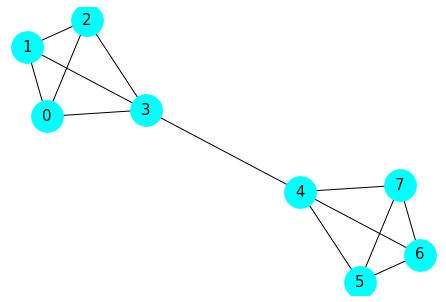

In [8]:
g3 = nx.barbell_graph(4, 0)
nx.draw(g3, **plot_kw)

- Now consider `3`
- Notice that connection between `3` and any of `0` `1` `2` is somehow different from connection to `4`

- `3-4` is known as a **bridge**
  - A *bridge* is an edge that, if removed, would cause the nodes involved to be in different components of the graph

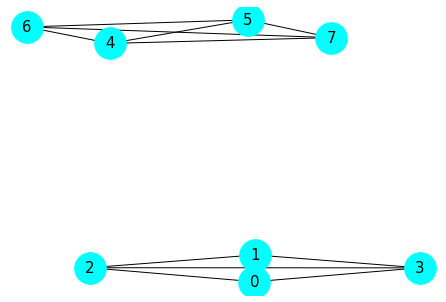

In [9]:
g4 = g3.copy()
g4.remove_edge(3, 4)
nx.draw(g4, **plot_kw)

### Frequency of bridges

- Given our discussion on triadic closure, bridges are likely to be rare in real social networks
- It is very likely that an edge will form between `4` and one of `0``1``2`
- Even if that isn't the case, consider the possibility that the graph we have been looking at is actually a smaller subset of a larger graph:

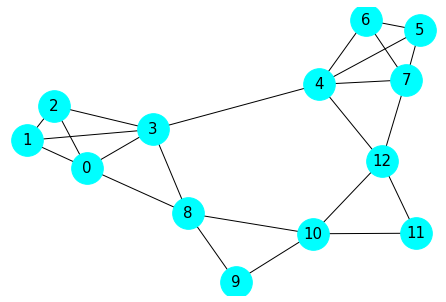

In [10]:
g5 = g3.copy()
[g5.add_node(i) for i in range(8, 13)]
new_edges = [
    (0, 8), (3, 8), (8, 9), (8, 10),
    (9, 10), (10, 11), (10, 12), (11, 12),
    (4, 12), (7, 12)
]
g5.add_edges_from(new_edges)
nx.draw(g5, **plot_kw)


### Local Bridges

- In the graph above even if `3-4` were broken, there would only be one component in our graph
  - In other words there is another path from `3` to `4` (here `3-8-10-12-4`)
- Because true bridges are so rare, a looser definition of bridge was created called a *local bridge*
- An edge `A-B` is a *local bridge* if `A` and `B` have no edges in common

### Detecting Local Bridges

- So far we have dealt with example graphs that we can visually inspect
- Most real world graphs are far to large for this
- To analyze larger graphs we need computational tools
- Let's build up some code that will allow us to find local bridges

In [11]:
def num_shared_neighbors(g: nx.Graph, n1, n2):
    """Compute the number of neighbors that n1 and n2 have in common

    Args:
        g (nx.Graph): A networkx graph
        n1, n2: Node labels
    """
    return len(set(g.neighbors(n1)) & set(g.neighbors(n2)))


- Now that we have a function for computing the number of shared neighbors, we can use it to build a routine for finding a local bridge
- We'll do that now

In [12]:
def local_bridges(g: nx.Graph):
    """Find all local bridges  in a graph

    Args:
        g (nx.Graph): a networkx graph
    """
    return (
        (u, v)
        for u, v in g.edges()
        if num_shared_neighbors(g, u, v) == 0
    )

### Example: Twitter connections

- Let's now consider an example using real social network data
- Below we'll load up a graph called `tw` that is a graph of connections between twitter users
- Each node is a different twitter account
- There is an edge between nodes if either one of the accounts follows the other

In [13]:
tw = nx.read_edgelist("./twitter_combined.txt")

In [14]:
len(tw.nodes), len(tw.edges)

(81306, 1342310)

- Notice that there are 81,306 nodes and 1,342,310 edges
- This is network is far to big to analyze visually
- Let's use a few of our empirical metrics to study the properties of this graph

In [14]:
%time sum(1 for _ in local_bridges(tw)) / len(tw.edges)

0.0037219420253145697

Notice how only 0.419% of edges form a local bridge!

## Edge Strength

- We have so far considered only whether or not two nodes are connected
- We have not discussed the strength of these connections
- We will now extend our analysis to the notion of an edge representing a strong or a weak tie
- In our friendship example, the strong ties would represent friends and the weak ties would represent acquaintances

### Strong and Weak ties

- In the figure below, we have a representation of a graph similar to our `g5` where all edges have been annotated with a `S` or a `W`
- A `S` edge represents a strong edge, or friendship
- A `W` edge represents a weak edge or, or acquaintance
  
![./strong_weak_ties.png](./strong_weak_ties.png)

### Triadic Closure: Strong Vs Weak

- Let's extend the inutition behind triadic closure to our strong/weak setting
- Our argument was that because we have edges `A-B` and `A-C`, it is likely that an edge `B-C` will form
- Now we'll state that if `A-B` and `A-C` are both strong ties, then it is more likely that `B-C` will form than if either `A-B` or `A-C` were weak
- More formally... we have  the *Strong Triadic Closure Property*
> We say that a node `A` violates the Strong Triadic Closure Property if it has strong ties to two other nodes `B` and `C`, and there is no edge at all (either a strong or weak tie) between `B` and `C`. We say that a node `A` satisfies the Strong Triadic Closure Property if it does not violate it.

### Local Bridges and Weak Ties

- Given this definition of the Strong Triadic Closure Property, we can make the following claim (see section 3.2 of E&K for proof, intuition in figure below):
> Claim: If a node A in a network satifies the Strong Triadic Closure Property and is involved in at least two strong ties, then any local bridge it is involved in must be a weak tie.

![./strong_triadic_closure.png](./strong_triadic_closure.png)

### Back to Granovetter

- Recall our original question: why do people report finding jobs through aquantainces (weak ties) more often than close friends (strong ties)?
- The Strong Triadic Closure Property gives the answer...
- Suppose `A` lost its job
  - By asking for a referral from any of `C`, `D`, or `E`; `A` is likely to get a similar set of information as they are strongly connected to one other and likely have access to the same set of information
  - Instead by talking to the weak tie `B`, `A` is likely to get new information from people in `B`'s social circle (including `H` and the three unlabeled nodes)
- tl;dr: local bridges are weak ties, so it is weak ties that get you access to "new" parts of the network

![./strong_weak_ties.png](./strong_weak_ties.png)

# Graph Partitioning

- Social networks often consist of tightly knit regions and weak ties that connect them
- One algorithmic problem that has is been studied and applied in many settings is that of graph partitioning
- To partition a graph is to break it down into the tightly-knit components
- When a graph is partitioned, it is broken down into components called *regions*

![./partitioning.png](./partitioning.png)

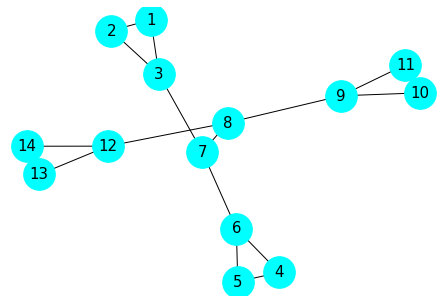

In [15]:
g6 = nx.Graph([
	(1,2), (1,3), (2,3), (3,7), (7,6), (6,4), (6,5), (4,5), (7,8),
	(8,9), (9,10), (10,11), (9,11), (8,12), (12,13), (13,14), (12,14)
])
nx.draw(g6, **plot_kw)

### Two Approaches

- There are to classes of algorithms that can be used to partition a graph:
  1. Divisive: partition a graph by removing local bridges ("spanning links")  and breaking down the network into large chunks
  2. Agglomerative: start with a single node and construct regions "bottom-up" by iteratively finding nodes highly connected to existing nodes in the region
- We'll focus on divisive methods here

### Betweenness Centrality

- In order to build a divisive partitioning algorithm, we'll first define a key metric for analyzing how "central" a node is in a network
- We'll provide a brief introduction here, and refer you to section 3.6 of E&K for more detail
- Let $V$ represent set of all nodes and $s, t, v \in V$
- Let $\sigma_{st}$ represent the number of shortest paths between $s$ and $t$
- Let $\sigma_{st}(v)$ represent the number of shortest paths between $s$ and $t$ that pass through $v$.
- Then, the **betweeness centrality**  for node $v$ ($C_{B}(v)$) is defined as: 
$$C_{B}(v) = \sum_{s \ne v \ne t \in V} \frac{\sigma_{st}(v)}{\sigma_{st}}$$
- Conceptually, $C_B(v)$ captures how much information "flows" across node $v$ on average

### Computing $C_B(v)$

- There are various algorithms we could use to compute $C_B(v)$
- For now we will let networkx handle it for us ;)

In [16]:
nx.betweenness_centrality(g6)

{1: 0.0,
 2: 0.0,
 3: 0.28205128205128205,
 7: 0.6538461538461539,
 6: 0.28205128205128205,
 4: 0.0,
 5: 0.0,
 8: 0.6538461538461539,
 9: 0.28205128205128205,
 10: 0.0,
 11: 0.0,
 12: 0.28205128205128205,
 13: 0.0,
 14: 0.0}

- Note that `7` and `8` are a local bridge
- Also note that they carry the highest value of $C_B$...

### Algorithm: Girvan-Newman

- We will not present the algorithm in detail, but will describe the overall steps
- Refer to Section 3.6 of E&K for details
- The Girvan-Newman algorithm for graph partitioning:
  - Inputs: graph
  - Outputs: list of edges to delete at each step
  - Algorithm:
    1. Find nodes with highest betweenness centrality -- remove them from the network (and add edges connecting them to the network to the list of deleted edges for first step)
    2. Re-compute betweenness centrality for all subgraphs that resulted from deletion in step 1. Remove all nodes with highest betweenness centrality and record list of deleted edges
    3. Continue until all edges have been removed

## Summary: Key ideas


- Triangles are key network structures
- Closed triangles are common in social networks due to tradic closure
- Social networks are often composed of tightly knit regions bound together with weak ties
- Weak ties often form local bridges and are therefore valueable for referrals and information flow
- Betwenness centrality captures idea of how essential a node is in connecting regions of a graph (how much information flows across a node)